In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Multiply
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

2023-07-21 01:50:33.962353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 01:50:34.060488: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/diana/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-07-21 01:50:34.060501: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-21 01:50:34.567926: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dler

In [2]:
# Sample image paths
image_paths = [
    'Dataset/train/three of diamonds/006.jpg',
    'Dataset/train/ace of clubs/066.jpg',
    'Dataset/train/ace of clubs/047.jpg',
    'Dataset/train/three of diamonds/002.jpg',
    'Dataset/train/ace of diamonds/064.jpg',
    'Dataset/train/ace of diamonds/063.jpg',
    'Dataset/train/nine of clubs/024.jpg',
    'Dataset/train/nine of clubs/070.jpg'
]

# ResNet

In [3]:
# Load the pre-trained ResNet model
resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

2023-07-21 01:50:35.371555: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/diana/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-07-21 01:50:35.371583: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-21 01:50:35.371613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (diana-MS-7D19): /proc/driver/nvidia/version does not exist
2023-07-21 01:50:35.371835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate c

1/1 [==============================] - 0s 67ms/step


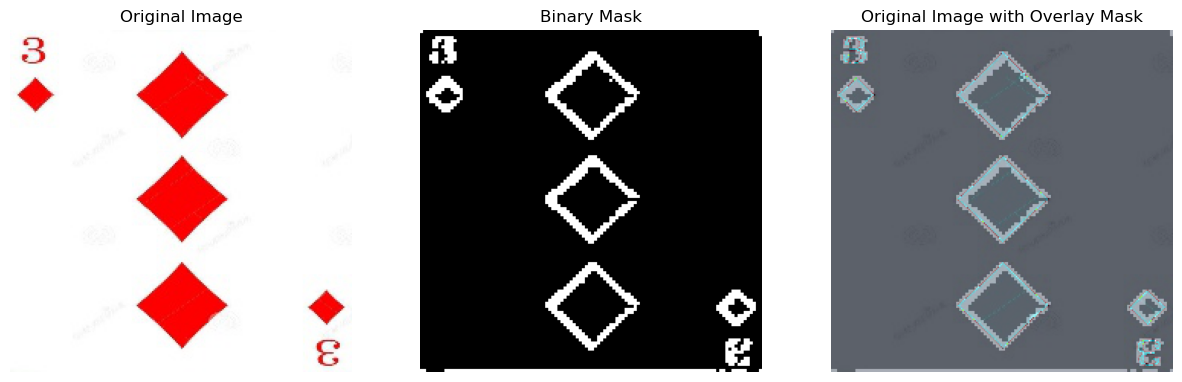

1/1 [==============================] - 0s 37ms/step


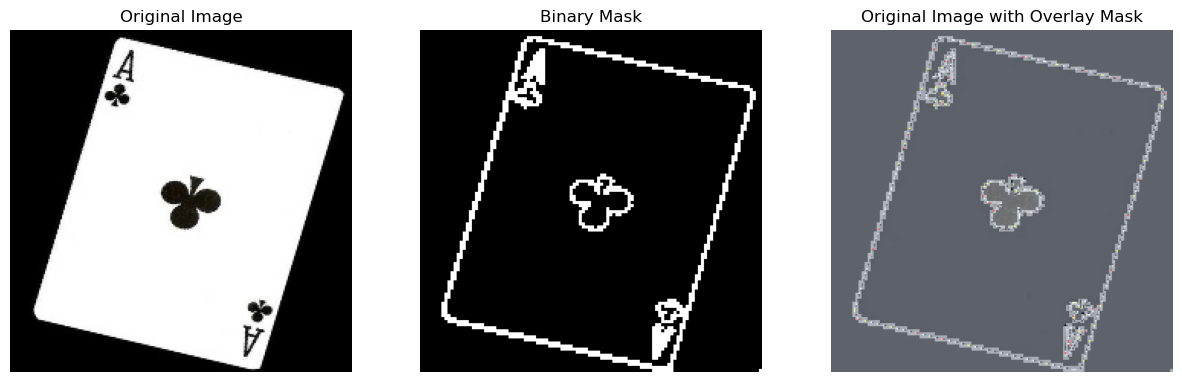

1/1 [==============================] - 0s 38ms/step


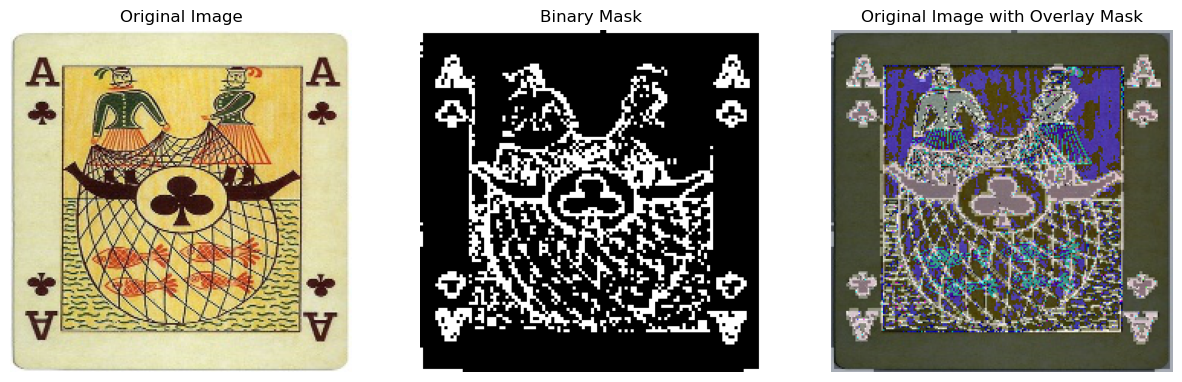

1/1 [==============================] - 0s 35ms/step


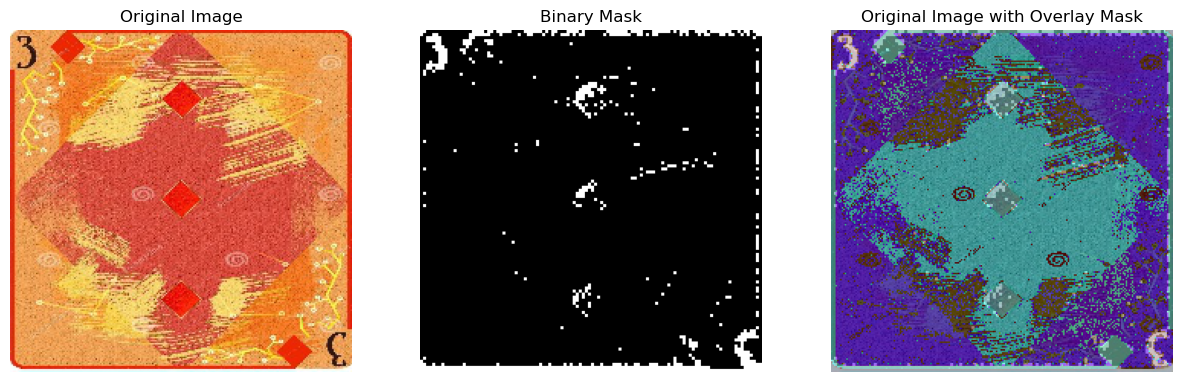

1/1 [==============================] - 0s 37ms/step


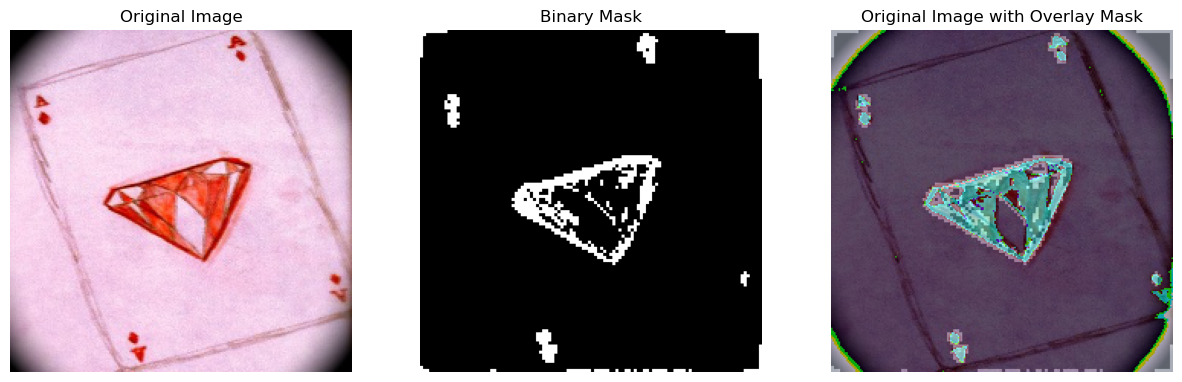

1/1 [==============================] - 0s 36ms/step


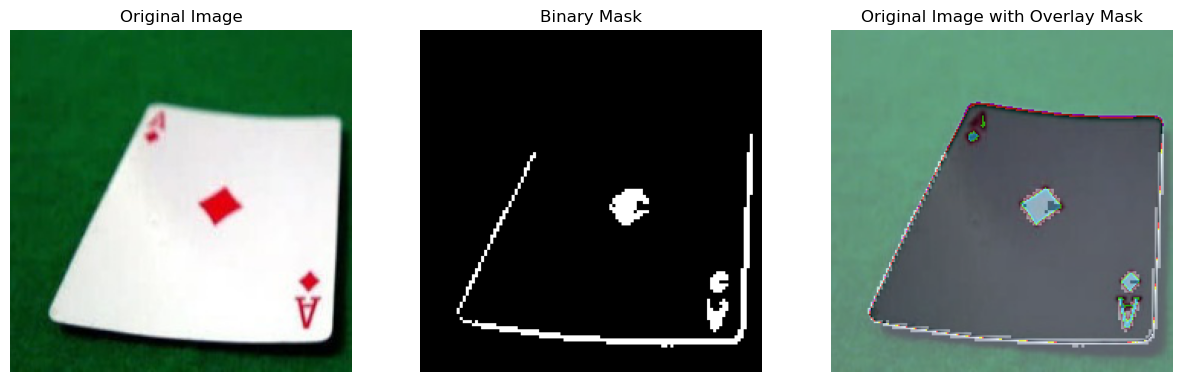

1/1 [==============================] - 0s 36ms/step


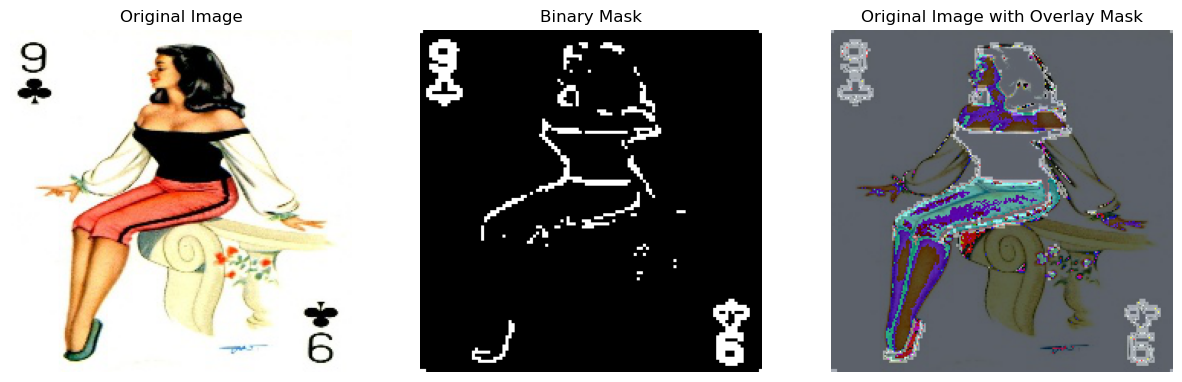

1/1 [==============================] - 0s 40ms/step


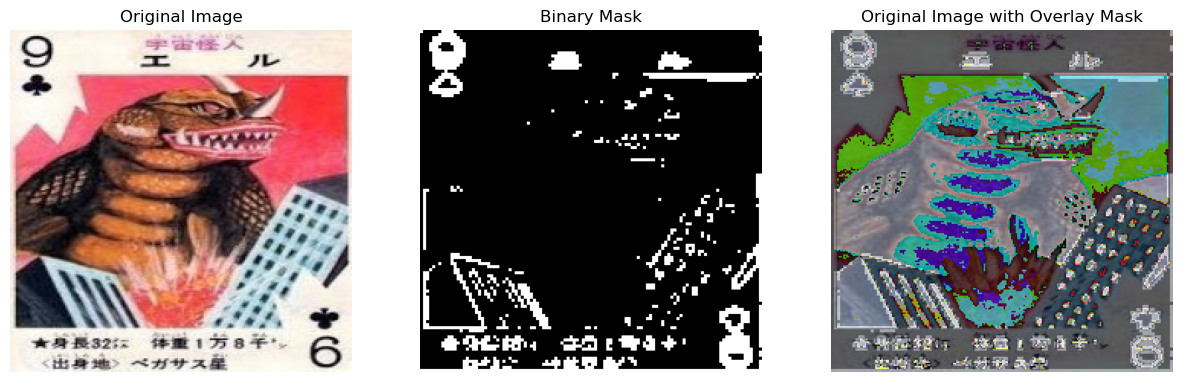

In [4]:
# Plot feature maps
def feature_maps(img_path, layer_index=4, threshold=0.4):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    preprocessed_img = preprocess_input(img_array)
    
    # Extract the feature maps for the given layer index
    layer_output = resnet.layers[layer_index].output
    model = Model(inputs=resnet.input, outputs=layer_output)
    feature_maps = model.predict(np.expand_dims(preprocessed_img, axis=0))
    
    # Get a 2D activation map
    activation_map = np.sum(feature_maps[0], axis=-1)
    
    # Normalize the activation map for visualization
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    
    # Apply a threshold to the activation map to concentrate on the feature
    binary_mask = activation_map > threshold
    
    # Resize the binary mask to match the dimensions of the original image
    binary_mask_resized = cv2.resize(binary_mask.astype(np.uint8), (img.width, img.height))
    
    # Convert the binary mask to a 3-channel (RGB) image
    binary_mask_3d = np.repeat(binary_mask_resized[..., np.newaxis], 3, axis=-1)
    
    # Apply the binary mask on the original image
    concentrated_img = img_array * binary_mask_3d
    
    # Convert the activation map to a 3-channel (RGB) image
    overlay_mask = np.uint8(255 * binary_mask_resized)
    overlay_mask = cv2.merge((overlay_mask, overlay_mask, overlay_mask))
    
    # Apply the overlay mask on the original image
    overlay_masked_img = cv2.addWeighted(img_array.astype(np.uint8), 0.7, overlay_mask, 0.3, 0)
    
    # Plot the original image, the binary mask, and the overlay masked image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(binary_mask_resized.astype(np.uint8), cmap='gray')
    plt.title('Binary Mask')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(overlay_masked_img.astype(np.uint8))
    plt.title('Original Image with Overlay Mask')
    plt.axis('off')
    plt.show()

    
for img_path in image_paths:
    feature_maps(img_path)

# Other Feature Detection

## FAST (Features from Accelerated Segment Test)

- A corner detection algorithm.
- Fast and efficient in detecting keypoints or corners.

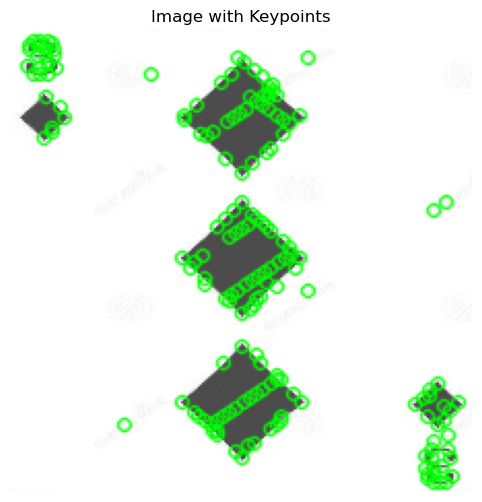

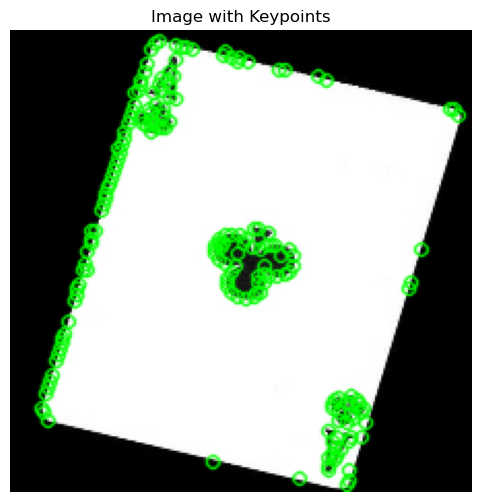

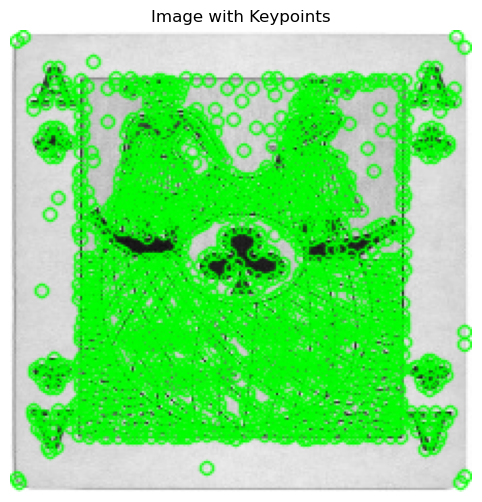

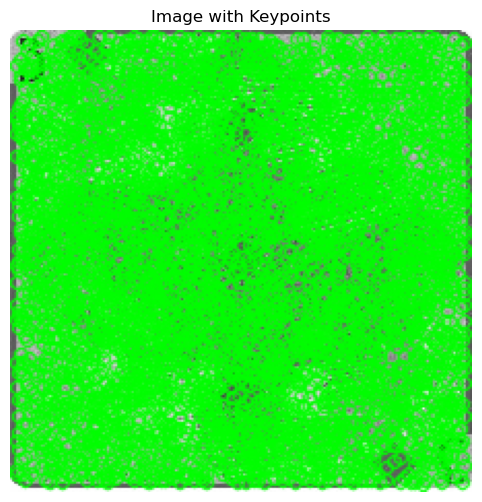

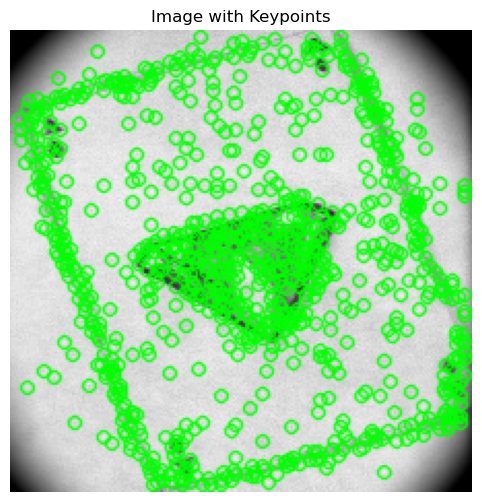

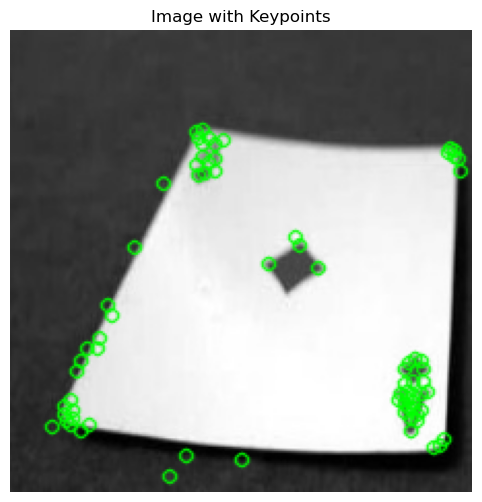

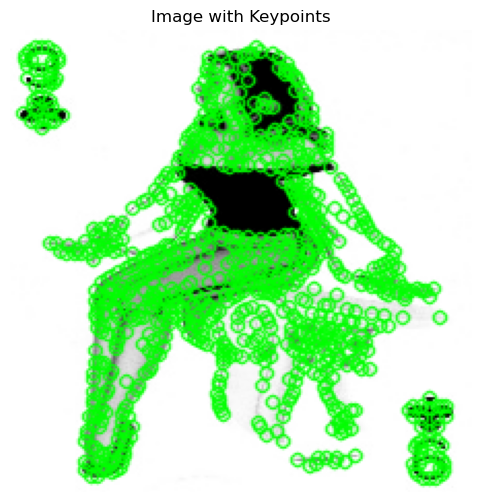

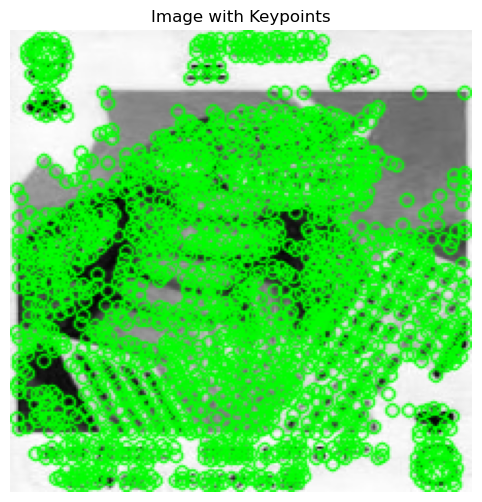

In [5]:
# FAST, corner detection
fast = cv2.FastFeatureDetector_create()

for img_path in image_paths:
    # Load the original image in grayscale
    original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Detect keypoints
    keypoints = fast.detect(original_img, None)

    # Draw keypoints on the original image
    keypoints_img = cv2.drawKeypoints(original_img, keypoints, None, color=(0, 255, 0), flags=0)
    keypoints_img_rgb = cv2.cvtColor(keypoints_img, cv2.COLOR_BGR2RGB)

    # Display the original image with keypoints
    plt.figure(figsize=(8, 6))
    plt.imshow(keypoints_img_rgb)
    plt.title("Image with Keypoints")
    plt.axis('off')
    plt.show()

## ORB (Oriented FAST and Rotated BRIEF) 

- A feature detection and descriptor extraction algorithm.
- ORB is useful in tasks like object recognition, image matching, and visual tracking. It is an enhancement of the FAST (Features from Accelerated Segment Test) corner detector and the BRIEF (Binary Robust Independent Elementary Features) descriptor.

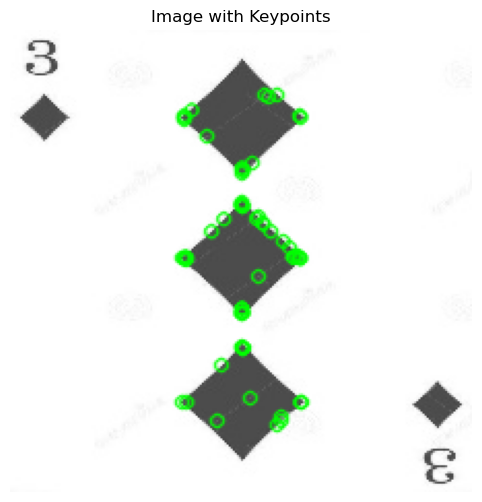

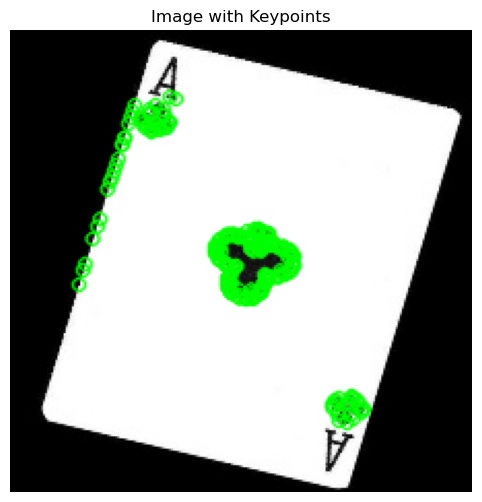

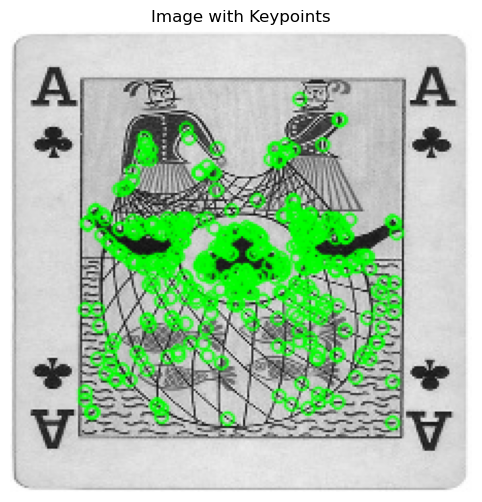

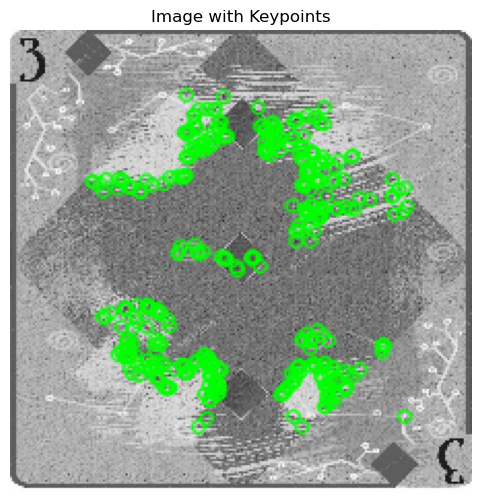

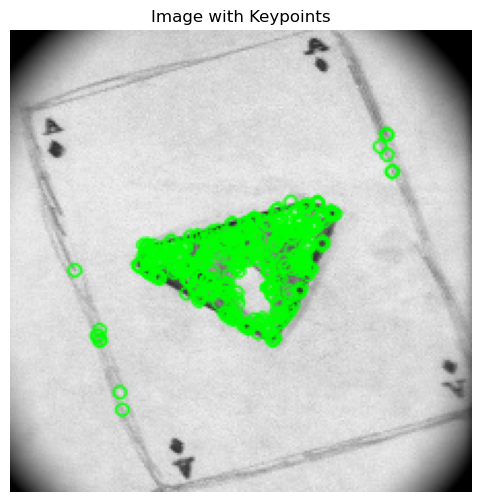

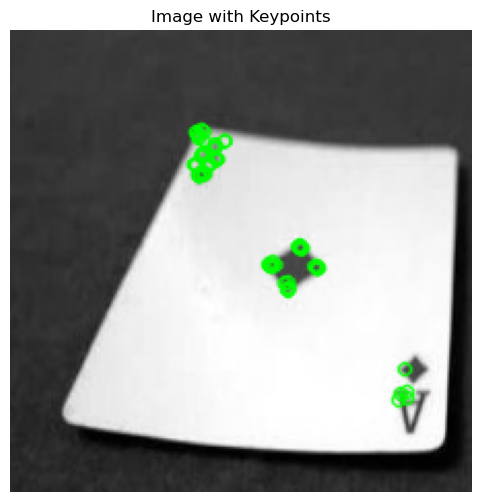

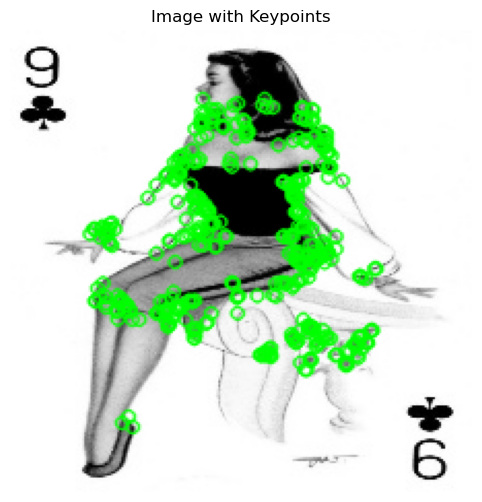

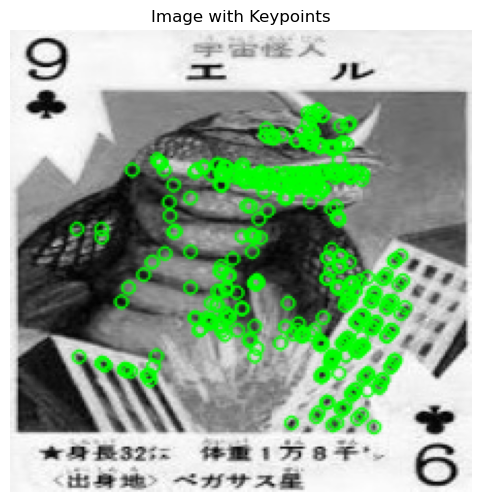

In [6]:
# ORB, image matching
orb = cv2.ORB_create()

for img_path in image_paths:
    # Load the original image as grayscale
    original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Detect keypoints
    keypoints, descriptors = orb.detectAndCompute(original_img, None)

    # Draw keypoints on the original image
    keypoints_img = cv2.drawKeypoints(original_img, keypoints, None, color=(0, 255, 0), flags=0)

    keypoints_img_rgb = cv2.cvtColor(keypoints_img, cv2.COLOR_BGR2RGB)

    # Display the original image with keypoints
    plt.figure(figsize=(8, 6))
    plt.imshow(keypoints_img_rgb)
    plt.title("Image with Keypoints")
    plt.axis('off')
    plt.show()